In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score

In [2]:
!pip install librosa

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
filename='Cuckoo/Guira/Guira_Cuckoo001.wav'

In [5]:
import IPython.display as ipd
import librosa
import librosa.display

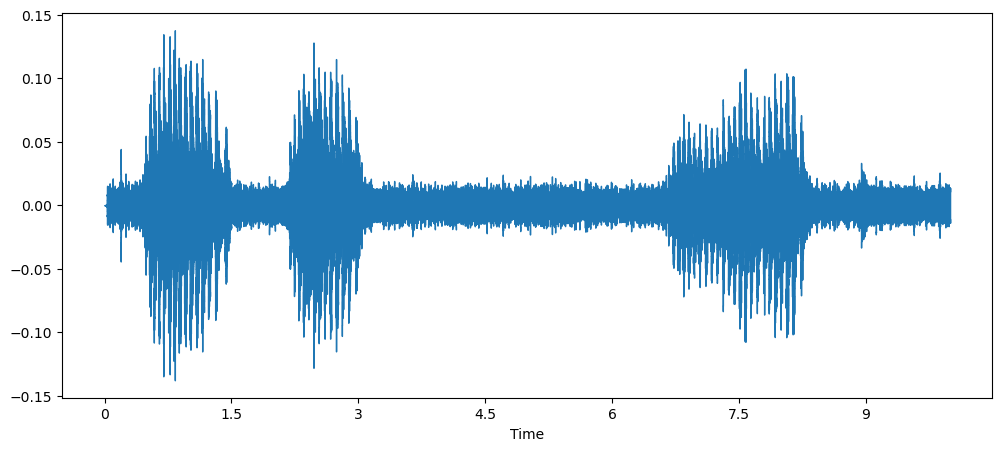

In [6]:
#Guira Cuckoo Sound
plt.figure(figsize=(12,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(filename)

In [7]:
sample_rate #Sample rate how many times per second sound is sampled
#librosa will read audio file and convert to audio file into smaple rate of 22050
#librosa convert the stereo sound to mono and normalize the data within range

22050

In [8]:
#Stereo: different sound on rhs and lhs and thus convert it to mono

In [9]:
from scipy.io import wavfile as wav
wave_sample_rate,wave_audio=wav.read(filename)

In [10]:
wave_sample_rate

44100

In [11]:
wave_audio # 2 channels stereo sound through scipy.io

array([[   0,    0],
       [   0,    0],
       [   0,    0],
       ...,
       [  -7, -255],
       [ -93, -136],
       [-164, -101]], dtype=int16)

In [12]:
data # 1 channel mono through librosa

array([-3.4924597e-10, -6.9849193e-10, -3.4924597e-10, ...,
       -7.0617171e-03, -4.5218109e-03, -4.1889325e-03], dtype=float32)

In [13]:
import os
import pathlib
import tensorflow as tf

# Feature Extraction

Mel-Frequency Cepstral Coefficients(MFCC): Summarizes the frequency distribution across the window size so that it is possible to analyze bothe the frquency and time characteristics of the sound ; allow us to identify features for classification

In [14]:
mfcc=librosa.feature.mfcc(y=data,sr=sample_rate,n_mfcc=40) #40 parameters
print(mfcc.shape)

(40, 431)


In [15]:
mfcc # Patterns that have been extracted based on the frequency and time characteristics
# Uniquely identifies the particular audio signal in which class it actually belongs

array([[-5.1161349e+02, -3.7179620e+02, -3.3417239e+02, ...,
        -3.4013760e+02, -3.3735727e+02, -3.4497873e+02],
       [ 7.7902100e+01,  7.3147758e+01,  6.8940918e+01, ...,
         6.8618134e+01,  7.0769424e+01,  7.1448853e+01],
       [ 9.8484526e+00,  1.3745153e+01,  8.4822054e+00, ...,
         1.1222051e+01,  8.6986742e+00,  1.0408589e+01],
       ...,
       [-2.2613742e+00,  9.1270626e-01, -1.1152542e+00, ...,
         1.6866845e+00,  2.3645043e-01, -2.2039094e+00],
       [-1.3536116e+01, -8.1151304e+00, -3.1431057e+00, ...,
         1.8810059e+00,  5.7593656e-01, -2.5818532e+00],
       [ 3.8680296e+00,  1.9298193e+00,  3.5221190e+00, ...,
         1.3661121e+01,  8.6896248e+00,  2.3941550e+00]], dtype=float32)

In [16]:
# Folder Structure
data_dir = 'Cuckoo'
classes = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Species:', classes)

Species: ['Guira' 'Pheasant' 'Striped']


In [17]:
#Extacting MFCC's for every audio file
def load_and_feature_extract(data_dir, classes, target_shape=(128, 128)):
    data=[]
    labels=[]
    for i,class_name in enumerate(classes):
        class_dir=os.path.join(data_dir,class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path=os.path.join(class_dir,filename)
                audio,sample_rate=librosa.load(file_path,res_type='kaiser_fast')
                mfccs_features=librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
                mfccs_scaled_features=np.mean(mfccs_features.T,axis=0)
                # To find scaled feature, we do the mean on the transposed value   
                data.append(mfccs_scaled_features)
                labels.append(class_name)
    df = pd.DataFrame({"Feature": data, "label": labels})
    return df
#     return np.array(data),np.array(labels)

In [18]:
# classes=['Guira','Pheasant','Striped']
# data_dir='Cuckoo'
df=load_and_feature_extract(data_dir,classes)

In [19]:
df

,Feature,label
0,"[-319.94962, 65.4234, -2.0694883, 40.764893, -...",Guira
1,"[-353.16095, 134.66312, -28.427298, 16.765083,...",Guira
2,"[-53.099903, 116.39202, -43.467163, 23.106602,...",Guira
3,"[-200.77414, 30.666603, -49.187843, 34.521927,...",Guira
4,"[-321.00574, 18.957237, -20.195799, 61.027367,...",Guira
...,...,...
295,"[-281.2956, 134.31966, -82.61982, 74.98636, -2...",Striped
296,"[-476.87668, 70.35261, -2.45378, 27.395977, -8...",Striped
297,"[-454.50076, 64.63547, -3.7291045, 32.749477, ...",Striped
298,"[-453.18427, 74.78043, -6.515326, 36.08191, -1...",Striped


In [20]:
#Split dataset into independent and dependent dataset
X=np.array(df['Feature'].tolist())
Y=np.array(df['label'].tolist())

In [21]:
X.shape

(300, 40)

In [22]:
### Label Encoding
###y=np.array(pd.get_dummies(y))
### Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
Y=to_categorical(labelencoder.fit_transform(Y))

In [23]:
Y.shape

(300, 3)

In [24]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=0)

In [25]:
X_train.shape

(240, 40)

In [26]:
X_test.shape

(60, 40)

In [27]:
X_train

array([[-3.20439545e+02,  6.66597595e+01, -1.21078396e+01, ...,
         5.71018830e-02,  7.00347841e-01,  9.47589159e-01],
       [-1.57843262e+02,  8.82138977e+01, -6.29095802e+01, ...,
        -5.32346427e-01, -1.69814718e+00, -3.59235585e-01],
       [-4.13956421e+02, -3.71432724e+01, -1.39253159e+01, ...,
         3.45122784e-01, -8.62048924e-01,  1.22818255e+00],
       ...,
       [-7.36799805e+02, -1.34571612e+00, -2.83454895e+01, ...,
        -1.05468798e+00, -1.30978835e+00,  1.20223129e+00],
       [-4.03059174e+02,  9.02678757e+01, -4.08410225e+01, ...,
         1.67075172e-01, -2.18860641e-01, -2.06809664e+00],
       [-2.99295471e+02,  8.19187851e+01, -1.45859995e+01, ...,
         4.69796371e+00, -1.36548812e-02,  2.90481687e+00]], dtype=float32)

In [28]:
Y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

# Model Creation

In [29]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [31]:
# No. of classes
num_labels=Y.shape[1]

In [32]:
num_labels

3

In [33]:
#ANN with 3 dense layers
model=Sequential()
# First Layer
model.add(Dense(100,input_shape=(40,))) # input_shape=(40,) as we had 40 features in training dataset
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Second Layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Third Layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#Final Layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [35]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [38]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, Y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, Y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
1/8 [==>...........................] - ETA: 0s - loss: 0.6994 - accuracy: 0.6562
Epoch 1: val_loss improved from inf to 0.90656, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 0s 21ms/step - loss: 0.7662 - accuracy: 0.6500 - val_loss: 0.9066 - val_accuracy: 0.7333
Epoch 2/100
1/8 [==>...........................] - ETA: 0s - loss: 0.6547 - accuracy: 0.8125
Epoch 2: val_loss improved from 0.90656 to 0.89003, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 0s 13ms/step - loss: 0.7786 - accuracy: 0.6708 - val_loss: 0.8900 - val_accuracy: 0.7333
Epoch 3/100
1/8 [==>...........................] - ETA: 0s - loss: 0.9079 - accuracy: 0.6562
Epoch 3: val_loss improved from 0.89003 to 0.85423, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 0s 15ms/step - loss: 0.7623 - accuracy: 0.6833 - val_loss: 0.8542 - val_accuracy: 0.7333
Epoch 4/100
1/8 [==>

Epoch 29/100
1/8 [==>...........................] - ETA: 0s - loss: 0.7322 - accuracy: 0.6875
Epoch 29: val_loss did not improve from 0.75352
8/8 [==============================] - 0s 8ms/step - loss: 0.5561 - accuracy: 0.7708 - val_loss: 0.7924 - val_accuracy: 0.8000
Epoch 30/100
1/8 [==>...........................] - ETA: 0s - loss: 0.6758 - accuracy: 0.6250
Epoch 30: val_loss did not improve from 0.75352
8/8 [==============================] - 0s 9ms/step - loss: 0.5856 - accuracy: 0.7500 - val_loss: 0.7769 - val_accuracy: 0.8000
Epoch 31/100
1/8 [==>...........................] - ETA: 0s - loss: 0.5428 - accuracy: 0.7812
Epoch 31: val_loss did not improve from 0.75352
8/8 [==============================] - 0s 9ms/step - loss: 0.6070 - accuracy: 0.7708 - val_loss: 0.7809 - val_accuracy: 0.8000
Epoch 32/100
1/8 [==>...........................] - ETA: 0s - loss: 0.6400 - accuracy: 0.6562
Epoch 32: val_loss did not improve from 0.75352
8/8 [==============================] - 0s 8ms/step 

8/8 [==============================] - 0s 14ms/step - loss: 0.4591 - accuracy: 0.8083 - val_loss: 0.6738 - val_accuracy: 0.8667
Epoch 59/100
1/8 [==>...........................] - ETA: 0s - loss: 0.5971 - accuracy: 0.8125
Epoch 59: val_loss did not improve from 0.67377
8/8 [==============================] - 0s 9ms/step - loss: 0.5127 - accuracy: 0.8208 - val_loss: 0.6779 - val_accuracy: 0.8667
Epoch 60/100
1/8 [==>...........................] - ETA: 0s - loss: 0.4599 - accuracy: 0.7812
Epoch 60: val_loss did not improve from 0.67377
8/8 [==============================] - 0s 10ms/step - loss: 0.4567 - accuracy: 0.8042 - val_loss: 0.6744 - val_accuracy: 0.8500
Epoch 61/100
1/8 [==>...........................] - ETA: 0s - loss: 0.4081 - accuracy: 0.7812
Epoch 61: val_loss improved from 0.67377 to 0.66545, saving model to saved_models\audio_classification.hdf5
8/8 [==============================] - 0s 25ms/step - loss: 0.5140 - accuracy: 0.8083 - val_loss: 0.6654 - val_accuracy: 0.8500
Epo

1/8 [==>...........................] - ETA: 0s - loss: 0.4575 - accuracy: 0.8125
Epoch 88: val_loss did not improve from 0.64301
8/8 [==============================] - 0s 8ms/step - loss: 0.3621 - accuracy: 0.8750 - val_loss: 0.6466 - val_accuracy: 0.8833
Epoch 89/100
1/8 [==>...........................] - ETA: 0s - loss: 0.4283 - accuracy: 0.7812
Epoch 89: val_loss did not improve from 0.64301
8/8 [==============================] - 0s 7ms/step - loss: 0.4143 - accuracy: 0.8458 - val_loss: 0.6546 - val_accuracy: 0.9000
Epoch 90/100
1/8 [==>...........................] - ETA: 0s - loss: 0.2434 - accuracy: 0.9688
Epoch 90: val_loss did not improve from 0.64301
8/8 [==============================] - 0s 8ms/step - loss: 0.3341 - accuracy: 0.8958 - val_loss: 0.6816 - val_accuracy: 0.8667
Epoch 91/100
1/8 [==>...........................] - ETA: 0s - loss: 0.3420 - accuracy: 0.8438
Epoch 91: val_loss did not improve from 0.64301
8/8 [==============================] - 0s 9ms/step - loss: 0.358

In [39]:
test_accuracy=model.evaluate(X_test,Y_test,verbose=0)
print(test_accuracy[1])

0.9166666865348816


In [60]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [42]:
filename="Guira_Cuckoo001.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=model.predict(mfccs_scaled_features)
print(predicted_label)

# Reshape to 1D array
predicted_label_1d = np.argmax(predicted_label, axis=1)

prediction_class=labelencoder.inverse_transform(predicted_label_1d)
prediction_class

[-319.94962     65.4234      -2.0694883   40.764893   -11.359847
   32.612385   -13.771595    17.644558   -13.044228    22.32312
  -13.078986    10.763883    -8.080789    15.728896   -16.036865
   11.619553    -7.387176     5.0774884   -1.0550797   -1.0346915
   -3.547365     7.337772    -6.869826     4.3230505   -5.8369074
    5.2668905   -3.5338407    0.6474463   -3.7500844    1.8137698
    0.679785    -5.033357     2.114961    -0.5094632   -1.1585351
    0.9062575   -2.783628     0.7647029    0.6159818   -3.0733225]
[[-319.94962     65.4234      -2.0694883   40.764893   -11.359847
    32.612385   -13.771595    17.644558   -13.044228    22.32312
   -13.078986    10.763883    -8.080789    15.728896   -16.036865
    11.619553    -7.387176     5.0774884   -1.0550797   -1.0346915
    -3.547365     7.337772    -6.869826     4.3230505   -5.8369074
     5.2668905   -3.5338407    0.6474463   -3.7500844    1.8137698
     0.679785    -5.033357     2.114961    -0.5094632   -1.1585351
     0.906

array(['Guira'], dtype='<U8')